In [52]:
# Cell 1: Required Imports
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import numdifftools as nd


In [57]:
# Cell 2: Test Functions Definitions

def quadratic_function(x):
    return 3*(x[0]-1)**2 + (x[1]-3)**2

def rosenbrock_function(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def himmelblaus_function(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def easom_function(x):
    return -np.cos(x[0]) * np.cos(x[1]) * np.exp(-(x[0] - np.pi)**2 - (x[1] - np.pi)**2)

def rastrigin_function(x):
    n = len(x)
    return 10*n + sum([xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x])



In [58]:
# Cell 3: Trust Region Subproblem Solver and η Update Function

def trust_region_subproblem(x, grad, hess, delta):
    # Solve the trust region subproblem (simplified version)
    p = -np.linalg.inv(hess).dot(grad)
    if np.linalg.norm(p) > delta:
        p = p / np.linalg.norm(p) * delta
    return p

def update_eta(k, eta_history, eta_0):
    if k == 1:
        return eta_0 / 2
    else:
        return (eta_history[-1] + eta_history[-2]) / 2


In [59]:
# Cell 4: NTR, NMTR-N1, and NMTR-N2 Algorithms

def ntr_algorithm(obj_func, start_point, max_iterations, initial_delta, eta, max_delta):
    x = start_point
    delta = initial_delta
    function_values = []

    for i in range(max_iterations):
        grad = opt.approx_fprime(x, obj_func, epsilon=1e-8)
        hess = nd.Hessian(obj_func)(x)
        p = trust_region_subproblem(x, grad, hess, delta)

        actual_reduction = obj_func(x) - obj_func(x + p)
        predicted_reduction = -grad.dot(p) - 0.5 * p.dot(hess).dot(p)

        if abs(predicted_reduction) > 1e-8:
            rho = actual_reduction / predicted_reduction
        else:
            rho = 0

        if rho < 0.25:
            delta *= 0.25
        elif rho > 0.75 and np.linalg.norm(p) == delta:
            delta = min(2.0 * delta, max_delta)

        if rho > eta:
            x = x + p

        function_values.append(obj_func(x))

    return x, function_values

def nmtr_algorithm(obj_func, start_point, max_iterations, initial_delta, eta, history_length, eta_0, max_delta):
    x = start_point
    delta = initial_delta
    f_history = [obj_func(x)]
    function_values = []
    eta_history = [eta_0]

    for k in range(1, max_iterations + 1):
        grad = opt.approx_fprime(x, obj_func, epsilon=1e-8)
        hess = nd.Hessian(obj_func)(x)
        p = trust_region_subproblem(x, grad, hess, delta)

        eta = update_eta(k, eta_history, eta_0)
        eta_history.append(eta)

        max_f = max(f_history[-min(k, history_length):])
        actual_reduction = max_f - obj_func(x + p)
        predicted_reduction = -grad.dot(p) - 0.5 * p.dot(hess).dot(p)

        if abs(predicted_reduction) > 1e-8:
            rho = actual_reduction / predicted_reduction
        else:
            rho = 0

        if rho < 0.25:
            delta *= 0.25

        elif rho > 0.75 and np.linalg.norm(p) == delta:
            delta = min(2.0 * delta, max_delta)

        if rho > eta:
            x = x + p
            f_history.append(obj_func(x))

        function_values.append(obj_func(x))

    return x, function_values

def nmtr_n1_algorithm(obj_func, start_point, max_iterations, initial_delta, eta, history_length, max_delta):
    # NMTR-N1 uses a specific eta_0 value
    eta_0_n1 = 0.85
    return nmtr_algorithm(obj_func, start_point, max_iterations, initial_delta, eta, history_length, eta_0_n1, max_delta)

def nmtr_n2_algorithm(obj_func, start_point, max_iterations, initial_delta, eta, history_length, max_delta):
    # NMTR-N2 uses a different eta_0 value
    eta_0_n2 = 0.2
    return nmtr_algorithm(obj_func, start_point, max_iterations, initial_delta, eta, history_length, eta_0_n2, max_delta)


In [60]:
# Cell for Defining Algorithm Parameters

# Common parameters for both algorithms
max_iterations = 100
initial_delta = 1.0
eta = 0.1
max_delta = 10.0

# Additional parameters for NMTR
history_length = 10
eta_0 = 0.85



Running algorithms on Quadratic Function
NTR Result for Quadratic Function: Minimum at [0.99999999 2.99999999], Value: 2.0959335685165046e-16
NMTR-N1 Result for Quadratic Function: Minimum at [0.99999999 2.99999999], Value: 2.0959335685165046e-16
NMTR-N2 Result for Quadratic Function: Minimum at [0.99999999 2.99999999], Value: 2.0959335685165046e-16


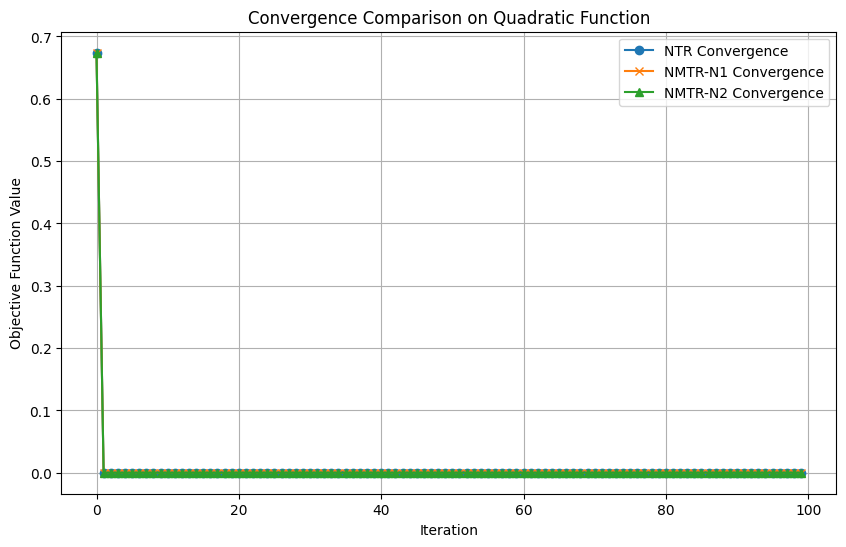


Running algorithms on Rosenbrock Function
NTR Result for Rosenbrock Function: Minimum at [0.99999634 0.99999267], Value: 1.3423192300418057e-11
NMTR-N1 Result for Rosenbrock Function: Minimum at [0.99999699 0.99999295], Value: 1.150344267665643e-10
NMTR-N2 Result for Rosenbrock Function: Minimum at [0.99999699 0.99999295], Value: 1.150344267665643e-10


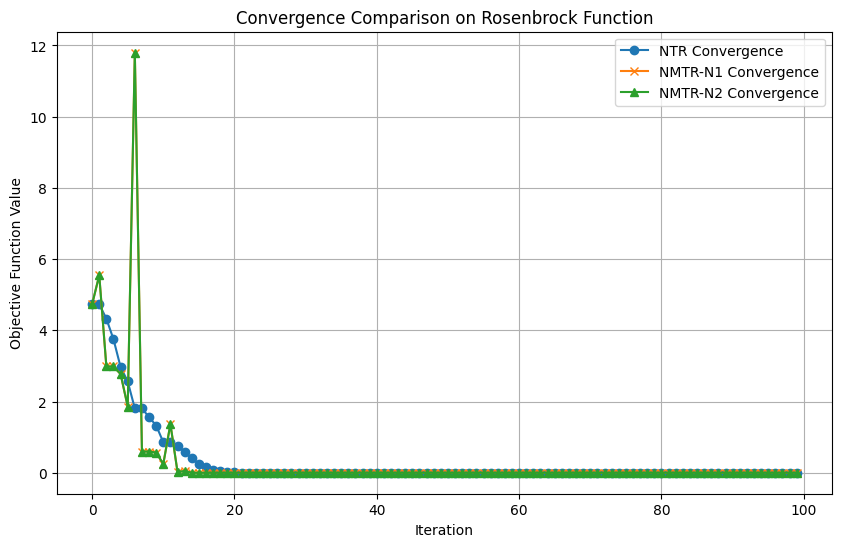


Running algorithms on Himmelblau's Function
NTR Result for Himmelblau's Function: Minimum at [-2.80512045  3.13131287], Value: 1.857012107722201e-10
NMTR-N1 Result for Himmelblau's Function: Minimum at [-2.80512045  3.13131287], Value: 1.857012107722201e-10
NMTR-N2 Result for Himmelblau's Function: Minimum at [-2.80512045  3.13131287], Value: 1.857012107722201e-10


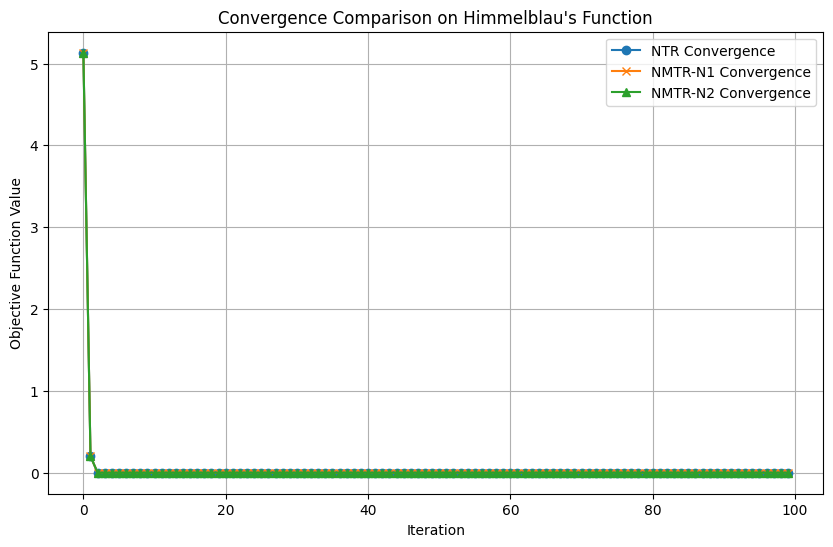


Running algorithms on Easom Function
NTR Result for Easom Function: Minimum at [3.14155547 3.14155547], Value: -0.9999999958522165
NMTR-N1 Result for Easom Function: Minimum at [3.14155547 3.14155547], Value: -0.9999999958522165
NMTR-N2 Result for Easom Function: Minimum at [3.14155547 3.14155547], Value: -0.9999999958522165


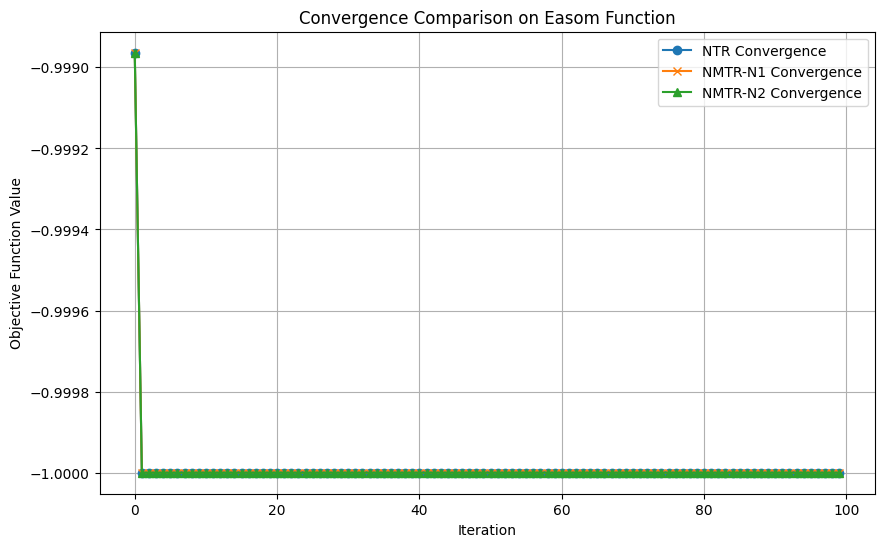


Running algorithms on Rastrigin Function
NTR Result for Rastrigin Function: Minimum at [0 0], Value: 0.0
NMTR-N1 Result for Rastrigin Function: Minimum at [0 0], Value: 0.0
NMTR-N2 Result for Rastrigin Function: Minimum at [0 0], Value: 0.0


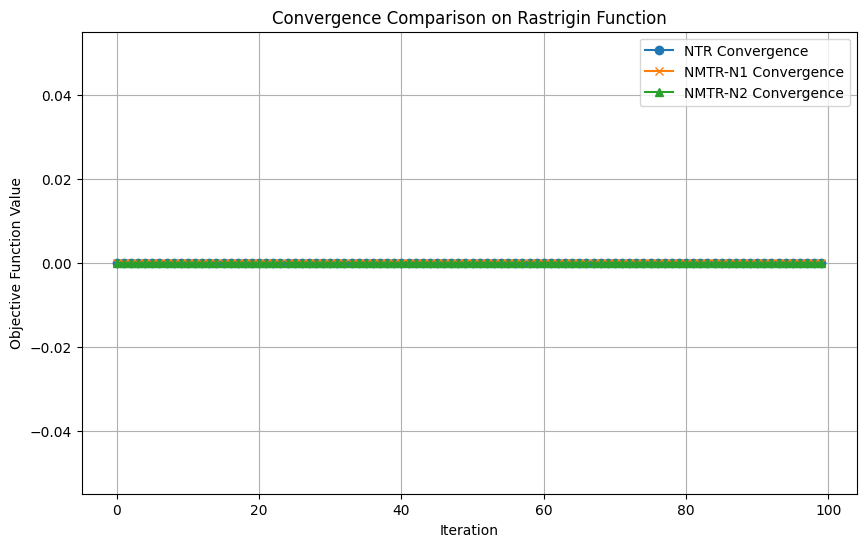

In [61]:
# Cell 5: Running Algorithms on Each Test Function and Plotting Results

test_functions = [quadratic_function, rosenbrock_function, himmelblaus_function, easom_function, rastrigin_function]
function_names = ["Quadratic", "Rosenbrock", "Himmelblau's", "Easom", "Rastrigin"]
start_points = [np.array([1.2, 1.2]), np.array([-1.2, 1]), np.array([-2, 2]), np.array([3, 3]), np.array([0, 0])]

for func, name, start_point in zip(test_functions, function_names, start_points):
    print(f"\nRunning algorithms on {name} Function")

    # Run NTR, NMTR-N1, and NMTR-N2 algorithms with defined parameters
    ntr_result, ntr_values = ntr_algorithm(func, start_point, max_iterations, initial_delta, eta, max_delta)
    nmtr_n1_result, nmtr_n1_values = nmtr_n1_algorithm(func, start_point, max_iterations, initial_delta, eta, history_length, max_delta)
    nmtr_n2_result, nmtr_n2_values = nmtr_n2_algorithm(func, start_point, max_iterations, initial_delta, eta, history_length, max_delta)

    # Print results
    print(f"NTR Result for {name} Function: Minimum at {ntr_result}, Value: {func(ntr_result)}")
    print(f"NMTR-N1 Result for {name} Function: Minimum at {nmtr_n1_result}, Value: {func(nmtr_n1_result)}")
    print(f"NMTR-N2 Result for {name} Function: Minimum at {nmtr_n2_result}, Value: {func(nmtr_n2_result)}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(ntr_values, label='NTR Convergence', marker='o')
    plt.plot(nmtr_n1_values, label='NMTR-N1 Convergence', marker='x')
    plt.plot(nmtr_n2_values, label='NMTR-N2 Convergence', marker='^')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title(f'Convergence Comparison on {name} Function')
    plt.legend()
    plt.grid(True)
    plt.show()
